In [1]:
%load_ext autoreload
%autoreload 2

# Training PointNet on Rolling with DeepCORAL [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml-jku/simshift/blob/main/notebooks/tutorial.ipynb)
This tutorial notebook shows how to set up the SimShift pipeline. It will cover
- datasets
- PointNet training
- domain adaptation with DeepCORAL
- model evaluation and error distribution
- Visualization of model prediction and errors

In [2]:
import os

# for deterministic results
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # set to your GPU
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [3]:
from simshift.utils import set_seed

set_seed(42)

Random seed set as 42


## Datasets and domains
First, let's get the datasets. Running the next cell will download the rolling dataset from [Huggingface](https://huggingface.co/datasets/simshift/SIMSHIFT_data), and create a training and validation splits for source/target domains.

Samples are loaded into RAM (for the Rolling dataset, which is small) and field-wise (PEEQ, LE, mises_stress, stresses).

In [4]:
from simshift.data import get_rolling_dataset

(train_src, train_tgt), normalization_stats = get_rolling_dataset(
    split="train"
)

(val_src, val_tgt), _ = get_rolling_dataset(
    split="val",
    normalization_stats=normalization_stats
)

Loading data (split=val, domain=src): 100%|██████████| 868/868 [00:12<00:00, 68.55it/s] 
Loading data (split=val, domain=tgt): 0it [00:00, ?it/s]


In [5]:
from torch.utils.data import DataLoader


trainloader_src = DataLoader(train_src, 16, True, collate_fn=train_src.collate, drop_last=True)
trainloader_tgt = DataLoader(train_tgt, 16, True, collate_fn=train_tgt.collate, drop_last=True)

valloader_src = DataLoader(val_src, 16, collate_fn=val_src.collate)
valloader_tgt = DataLoader(val_tgt, 16, collate_fn=val_tgt.collate)

## Baseline model
Next, we create the PointNet baseline model. The architecture is based on the original [PointNet](https://arxiv.org/abs/1612.00593), with some tweaks to make it work in the context of domain adaptation.

In particular a latent conditioning code is concatenated to the global features in PointNet.

In [6]:
from simshift.models import PointNet


model = PointNet(
    n_conds=train_src.n_conds,  # rolling has 4 conditions
    latent_channels=8,  # size of the conditioning code
    output_channels=train_src.n_channels,  # number of output field channels
    pointnet_base=16,  # latent size of the pointnet mlps
    dropout_prob=0
)

## Domain Adaptation wrapper
In this example we take the Deep-CORAL loss for domain adaptation.

This is implemented as a wrapper around the model and optimizer, computes the task and DA losses and applies the updates.

In particular, DeepCORAL aligns source and target domains by matching their feature covariances: $\mathcal{L}_{\text{CORAL}} = \frac{1}{4d^2} \|\mathbf{C}^S - \mathbf{C}^T\|_F^2$

In [7]:
from simshift.da_algorithms import DeepCORAL


da_algorithm = DeepCORAL(
    device=device,
    model=model,  # wrapped pointnet
    opt_method=torch.optim.AdamW,  # wrapped optimizer
    opt_kwargs={"lr": 1e-3, "weight_decay": 1e-5},  # adam arguments
    da_loss_weight=1e-5,  # deepcoral loss weight
    use_ema=True,  # use exponential moving average to update a target network
    ema_decay=0.95,
)

## Trainer
The Trainer class handles:
- training loop and application of domain adaptation losses on target
- evaluation / metric computation, checkpoints and logging
- early stopping

The `.run()` method starts the training with the specified number of epochs

In [8]:
from simshift.train import Trainer
from simshift.eval import Metrics
from simshift.utils import Logger

N_EPOCHS = 500

trainer = Trainer(
    datasets=(train_src, train_tgt, val_src, val_tgt),
    dataloaders=(trainloader_src, valloader_src, trainloader_tgt, valloader_tgt),
    da_algorithm=da_algorithm,
    device=device,
    scheduler="cosine",
    n_epochs=N_EPOCHS,
    early_stopping_patience=100,
    logger=Logger("tutorial", n_epochs=N_EPOCHS),
    metrics=Metrics(),  # computes "mse_avg", "ae_avg", "mse_max", "ae_max"
)

In [9]:
trainer.run()

2025-06-11 10:16:38,700 - [010] train/mse_loss: 0.16733, train/da_loss: 3.88515, train/summed_loss: 0.16816, train/lr: 0.00100, val_source/mse_avg: 0.16008, val_source/ae_avg: 0.17205, val_source/mse_max: 48.12696, val_source/ae_max: 4.14258, 
2025-06-11 10:16:55,320 - [020] train/mse_loss: 0.06434, train/da_loss: 3.41869, train/summed_loss: 0.06463, train/lr: 0.00100, val_source/mse_avg: 0.05199, val_source/ae_avg: 0.10905, val_source/mse_max: 7.05141, val_source/ae_max: 1.85721, 
2025-06-11 10:17:11,871 - [030] train/mse_loss: 0.03918, train/da_loss: 4.67398, train/summed_loss: 0.03935, train/lr: 0.00099, val_source/mse_avg: 0.03274, val_source/ae_avg: 0.08689, val_source/mse_max: 5.84558, val_source/ae_max: 1.64720, 
2025-06-11 10:17:28,372 - [040] train/mse_loss: 0.02606, train/da_loss: 4.43029, train/summed_loss: 0.02616, train/lr: 0.00098, val_source/mse_avg: 0.02142, val_source/ae_avg: 0.07274, val_source/mse_max: 4.36195, val_source/ae_max: 1.48509, 
2025-06-11 10:17:44,863 - [

## Evaluation

For a quantitative evaluation of our model, let's have a look at the error distribution across the two domains.

In [10]:
from simshift.eval import evaluate_model


# load test sets and create dataloaders
(test_src, test_tgt), _ = get_rolling_dataset(
    split="test",
    normalization_stats=normalization_stats
)
testloader_src = DataLoader(test_src, 256, collate_fn=test_src.collate)
testloader_tgt = DataLoader(test_tgt, 256, collate_fn=test_tgt.collate)

Loading data (split=test, domain=tgt): 100%|██████████| 625/625 [00:07<00:00, 88.10it/s] 


In [11]:
# compute RMSE losses for all samples
losses_source = evaluate_model(model, testloader_src, device)
losses_target = evaluate_model(model, testloader_tgt, device)

print("Mean normalized RMSEs:")
print(f"Source: \t{losses_source.mean().item():.3f}")
print(f"Target: \t{losses_target.mean().item():.3f}")

Computing losses:   0%|          | 0/4 [00:00<?, ?it/s]

Computing losses: 100%|██████████| 3/3 [00:00<00:00, 26.98it/s]

Mean normalized RMSEs:
Source: 	0.037
Target: 	0.274


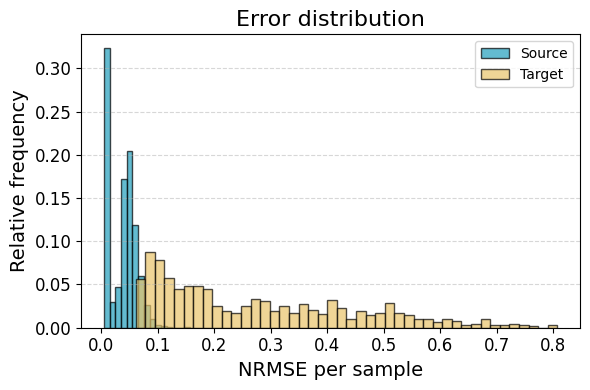

In [12]:
from simshift.eval.plotting import plot_error_distribution


# plot error distribution
error_distribution = plot_error_distribution(losses_source=losses_source, losses_target=losses_target)

The domain shift is clearly visible!

## Visualization

For a qualitative evaluation of our model, let's visualize the contour plots of ground truth, predicted and error meshes for some validation samples.

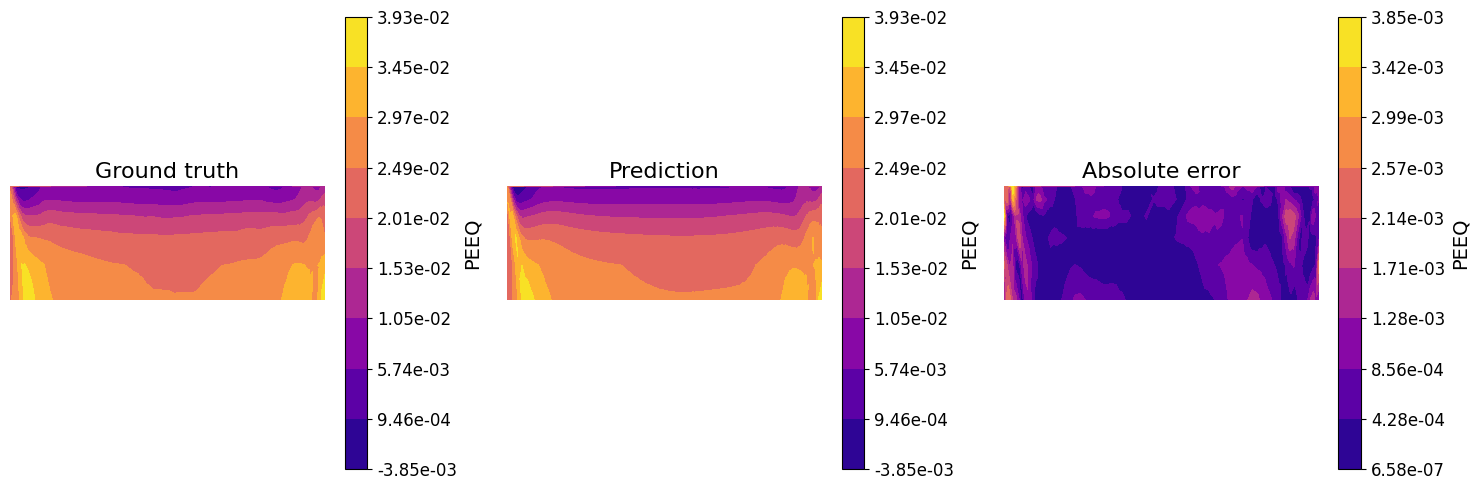

In [13]:
from simshift.eval.plotting import plot_rolling


idx = 500
with torch.no_grad():
    sample = test_src[idx]
    # create batch_index
    sample.batch_index = torch.zeros(sample.mesh_coords.shape[0], dtype=torch.long).to(device)
    sample.mesh_edges = sample.mesh_edges.T
    # condition batch dim
    sample.cond = sample.cond.unsqueeze(0).to(device)
    sample = sample.to(device)
    # forward pass
    pred, _ = model(**sample.as_dict())
    pred, pred_coords = pred

# denormalize
pred_denormalized = test_src.denormalize(None, pred.to("cpu"))
gt_denormalized = test_src.denormalize(None, sample.y.to("cpu"))
gt_mesh_coords_denormalized = test_src.denormalize_coords(sample.y_mesh_coords.to("cpu"))

# calculate absolute error
absolute_error = ((pred_denormalized - gt_denormalized)**2).sqrt()

# plot
visualization = plot_rolling(gt_mesh_coords_denormalized.detach(), gt_denormalized.detach(), pred_denormalized.detach(), absolute_error.detach(), channels={"PEEQ": test_src.channels["nodes_PEEQ"]}, aspect_ratio=4.5)

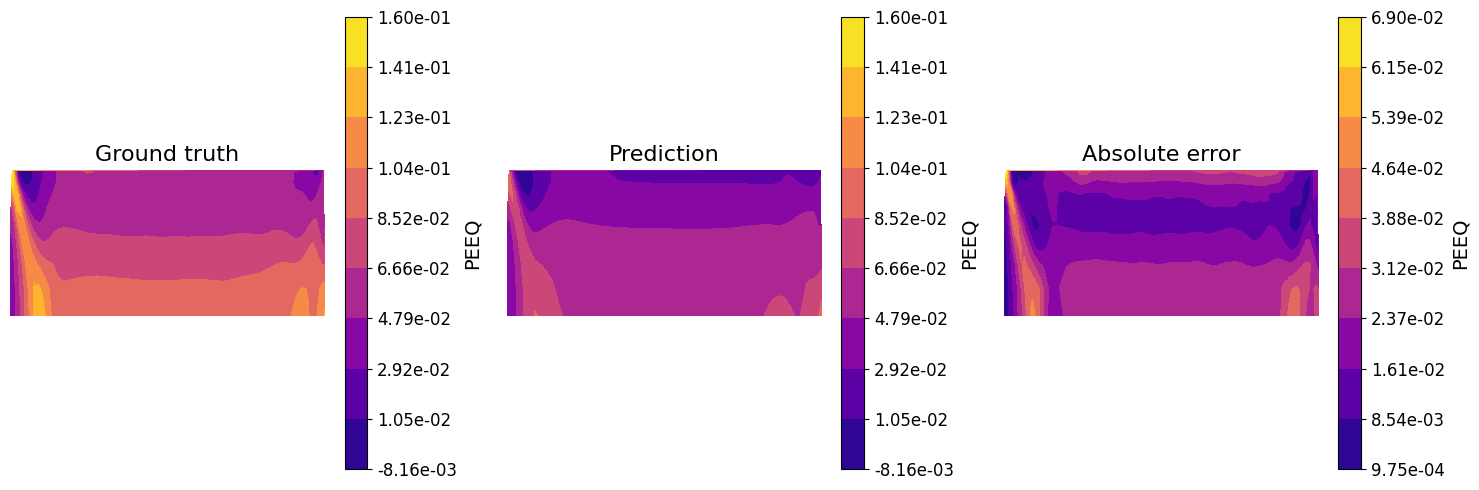

In [14]:
idx = 500
with torch.no_grad():
    sample = test_tgt[idx]
    # create batch_index
    sample.batch_index = torch.zeros(sample.mesh_coords.shape[0], dtype=torch.long).to(device)
    sample.mesh_edges = sample.mesh_edges.T
    # condition batch dim
    sample.cond = sample.cond.unsqueeze(0).to(device)
    sample = sample.to(device)
    # forward pass
    pred, _ = model(**sample.as_dict())
    pred, pred_coords = pred

# denormalize
pred_denormalized = test_src.denormalize(None, pred.to("cpu"))
gt_denormalized = test_src.denormalize(None, sample.y.to("cpu"))
gt_mesh_coords_denormalized = test_src.denormalize_coords(sample.y_mesh_coords.to("cpu"))

# calculate absolute error
absolute_error = ((pred_denormalized - gt_denormalized)**2).sqrt()

# plot
visualization = plot_rolling(gt_mesh_coords_denormalized.detach(), gt_denormalized.detach(), pred_denormalized.detach(), absolute_error.detach(), channels={"PEEQ": test_src.channels["nodes_PEEQ"]}, aspect_ratio=4.5)